# Depth Estimation Using Virtual Data

## How to use

Edit `REAL_FRACTION` and `VIRTUAL_FRACTION` below to control how much of each of the (real or virtual) datasets is used.

- `0` = None of the dataset is used
- `0.1` = 10% of the dataset is used
- `1` = All of the dataset

```
TODO: Example image saver callback
```

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from glob import glob
from natsort import natsorted
import numpy as np
from tqdm import tqdm
from pprint import pprint

from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, RandomHorizontalFlip, Lambda
import torchvision.transforms.functional as TF
import pytorch_lightning as pl
from pytorch_lightning.logging import TestTubeLogger
from torchsummary import summary

from kitti_adapt.depth.data import VkittiImageDataset, KittiDepthDataset
from kitti_adapt.depth.data.misc import mix_datasets, model_depth_output_to_numpy, compute_errors, evaluate_model
from kitti_adapt.depth.metrics import rmse_log, grad_loss, normal_loss, imgrad_yx
from kitti_adapt.depth.visualization import show_sample

# Define Model

In [3]:
# Architecture source: github.com/xanderchf/MonoDepth-FPN-PyTorch
def agg_node(in_planes, out_planes):
    return nn.Sequential(
        nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
    )

def smooth(in_planes, out_planes):
    return nn.Sequential(
        nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
    )

def predict(in_planes, out_planes):
    return nn.Sequential(
        nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=1, padding=1),
        nn.Sigmoid(),
    )

def upshuffle(in_planes, out_planes, upscale_factor):
    return nn.Sequential(
        nn.Conv2d(in_planes, out_planes*upscale_factor**2, kernel_size=3, stride=1, padding=1),
        nn.PixelShuffle(upscale_factor),
        nn.ReLU()
    )

class DepthEstimator(pl.LightningModule):
    def __init__(self, learning_rate=1e-5, log_images_every_n_steps=200, log_train_loss_every_n_steps=100, val_dataset=None):
        super().__init__()
        self.learning_rate = learning_rate
        self.log_images_every_n_steps = log_images_every_n_steps
        self.log_train_loss_every_n_steps = log_train_loss_every_n_steps
        self.val_dataset = val_dataset

        resnet = torchvision.models.resnet.resnet18(progress=True, pretrained=True)
        self.layer0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool)
        self.layer1 = nn.Sequential(resnet.layer1)
        self.layer2 = nn.Sequential(resnet.layer2)
        self.layer3 = nn.Sequential(resnet.layer3)
        self.layer4 = nn.Sequential(resnet.layer4)
        out_channels = self.layer4[-1][-1].conv2.out_channels
        # Top layer
        self.toplayer = nn.Conv2d(out_channels, 256, kernel_size=1, stride=1, padding=0)  # Reduce channels
        # Lateral layers
        self.latlayer1 = nn.Conv2d(out_channels // 2, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer2 = nn.Conv2d(out_channels // 4, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer3 = nn.Conv2d(out_channels // 8, 256, kernel_size=1, stride=1, padding=0)
        # Smooth layers
        self.smooth1 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.smooth2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.smooth3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        # Aggregate layers
        self.agg1 = agg_node(256, 128)
        self.agg2 = agg_node(256, 128)
        self.agg3 = agg_node(256, 128)
        self.agg4 = agg_node(256, 128)
        # Upshuffle layers
        self.up1 = upshuffle(128,128,8)
        self.up2 = upshuffle(128,128,4)
        self.up3 = upshuffle(128,128,2)
        # Depth prediction
        self.predict1 = smooth(512, 128)
        self.predict2 = predict(128, 1)

    def _upsample_add(self, x, y):
        '''Upsample and add two feature maps.
        Args:
          x: (Variable) top feature map to be upsampled.
          y: (Variable) lateral feature map.
        Returns:
          (Variable) added feature map.
        Note in PyTorch, when input size is odd, the upsampled feature map
        with `F.upsample(..., scale_factor=2, mode='nearest')`
        maybe not equal to the lateral feature map size.
        e.g.
        original input size: [N,_,15,15] ->
        conv2d feature map size: [N,_,8,8] ->
        upsampled feature map size: [N,_,16,16]
        So we choose bilinear upsample which supports arbitrary output sizes.
        '''
        _,_,H,W = y.size()
        return F.interpolate(x, size=(H,W), mode='bilinear') + y

    def forward(self, x):
        # Bottom-up
        c1 = self.layer0(x)
        c2 = self.layer1(c1)
        c3 = self.layer2(c2)
        c4 = self.layer3(c3)
        c5 = self.layer4(c4)
        # Top-down
        p5 = self.toplayer(c5)
        p4 = self._upsample_add(p5, self.latlayer1(c4))
        p4 = self.smooth1(p4)
        p3 = self._upsample_add(p4, self.latlayer2(c3))
        p3 = self.smooth2(p3)
        p2 = self._upsample_add(p3, self.latlayer3(c2))
        p2 = self.smooth3(p2)
        # Top-down predict and refine
        d5, d4, d3, d2 = self.up1(self.agg1(p5)), self.up2(self.agg2(p4)), self.up3(self.agg3(p3)), self.agg4(p2)
        _, _, H, W = d2.size()
        vol = torch.cat( [ F.interpolate(d, size=(H,W), mode='bilinear') for d in [d5,d4,d3,d2] ], dim=1 )        
        return self.predict2( self.predict1(vol) )     # img : depth = 4 : 1
    # =========================================
    # Vanilla PyTorch methods end here.
    # It's PyTorch Lightning from here on down.
    # =========================================

    def loss(self, pred, target):
        grad_pred, grad_target = imgrad_yx(pred), imgrad_yx(target)
        loss_grad = grad_loss(grad_pred, grad_target)
        loss_normal = normal_loss(grad_pred, grad_target)
        loss_depth = rmse_log(pred, target)
        return loss_depth + loss_grad + loss_normal

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.3)
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

    def training_step(self, batch, batch_nb):
        rgb = batch["rgb"]
        depth = batch["depth"]
        pred = self.forward(rgb)
        loss = self.loss(pred, depth)
        output = {"loss": loss}
        if batch_nb % self.log_train_loss_every_n_steps == 0:
            output["log"] = {"train_loss": loss}
        if self.val_dataset and batch_nb % self.log_images_every_n_steps == 0:
            self.generate_and_save_images(batch_nb)
        return output

    def validation_step(self, batch, batch_nb):
        rgb = batch["rgb"]
        depth = batch["depth"]
        pred = self.forward(rgb)
        loss = self.loss(pred, depth)
        return {"val_loss": loss}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        tensorboard_logs = {"val_loss": avg_loss}
        return {"avg_loss": avg_loss, "log": tensorboard_logs}

    # =========================================
    # Custom methods
    # =========================================
    def generate_and_save_images(self, batch_nb):
        experiment = self.logger.experiment
        save_path = Path(experiment.get_media_path(experiment.name, experiment.version)) / f"{batch_nb}.jpg"
        save_path.parent.mkdir(parents=True, exist_ok=True)
        device = next(model.parameters()).device
        rgb = self.val_dataset[0]["rgb"].to(device).unsqueeze(0)
        pred = F.interpolate(self(rgb), scale_factor=4, mode="bilinear")
        torchvision.utils.save_image(pred, str(save_path), nrow=1, normalize=True)


testmodel = DepthEstimator()

# Dataset Transforms

In [4]:
# Define transforms
def train_transform(sample):
    rgb = sample["rgb"]
    depth = sample["depth"]
    flip = np.random.uniform(0.0, 1.0) < 0.5
    rgb_transform = Compose([
        Resize([192,640]),
        RandomHorizontalFlip(flip),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    depth_transform = Compose([
        Resize([48,160]),
        RandomHorizontalFlip(flip),
        ToTensor(),
        Lambda(lambda x: x.float() / 65535),
    ])
    return {"rgb": rgb_transform(rgb), "depth": depth_transform(depth)}

def val_transform(sample):
    rgb = sample["rgb"]
    depth = sample["depth"]
    rgb_transform = Compose([
        Resize([192,640]),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    depth_transform = Compose([
        Resize([48,160]),
        ToTensor(),
        Lambda(lambda x: x.float() / 65535),
    ])
    return {"rgb": rgb_transform(rgb), "depth": depth_transform(depth)}

# Instantiate Datasets

Real sample:


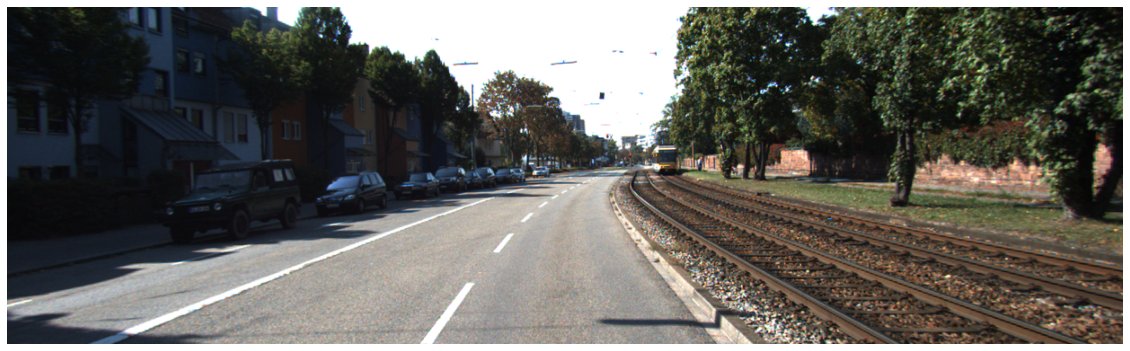

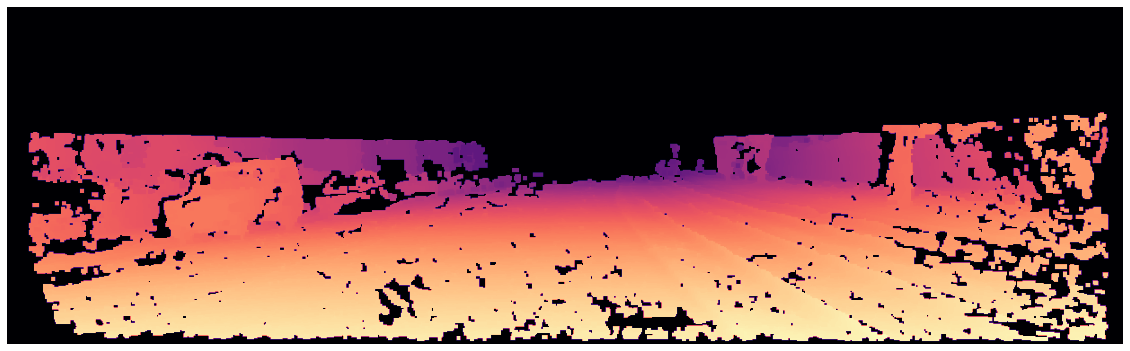

Virtual sample:


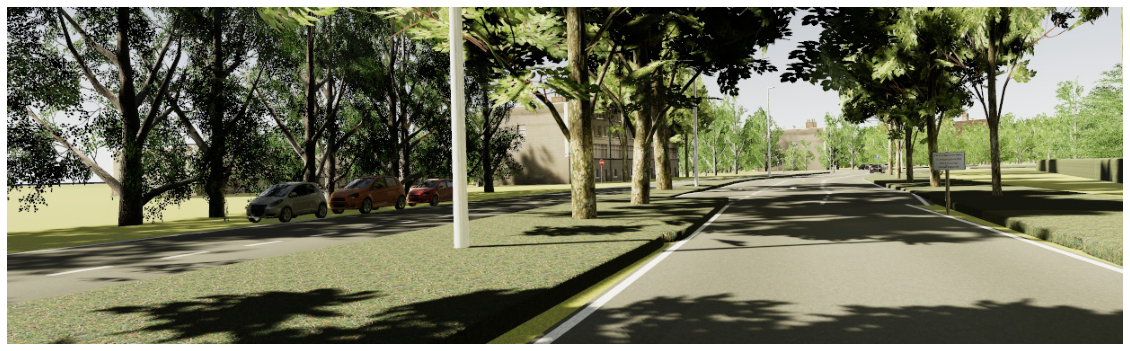

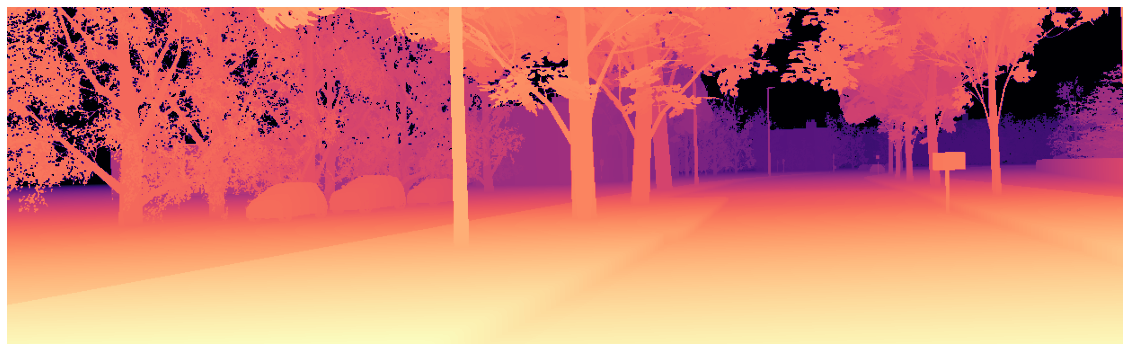

Real training samples = 29160
Virtual training samples = 10073


In [5]:
VKITTI_DIR = "../data/vkitti"
KITTI_DIR = "../data/kitti"

kitti_train_dataset = KittiDepthDataset(KITTI_DIR, transform=train_transform, subset="train")
kitti_val_dataset = KittiDepthDataset(KITTI_DIR, transform=val_transform, subset="test")
sample = kitti_train_dataset.get(0, transform=False)
print("Real sample:")
show_sample(**sample)
vkitti_train_dataset = VkittiImageDataset(VKITTI_DIR, scenes=["Scene02", "Scene06", "Scene18", "Scene20"], subsets=("rgb", "depth"), transform=train_transform)
vkitti_val_dataset = VkittiImageDataset(VKITTI_DIR, scenes=["Scene01"], subsets=("rgb", "depth"), transform=val_transform)
sample = vkitti_train_dataset.get(0, transform=False)
print("Virtual sample:")
show_sample(rgb=sample["rgb"], depth=sample["depth"])
print(f"Real training samples = {len(kitti_train_dataset)}")
print(f"Virtual training samples = {len(vkitti_train_dataset)}")

In [6]:
REAL_FRACTION = 0  # how much of the real dataset to use
VIRTUAL_FRACTION = 1  # how much of the virtual dataset to use
MODEL_NAME = f"{int(REAL_FRACTION * 100)}-real-{int(VIRTUAL_FRACTION * 100)}-virtual"
MODEL_PATH = f"../models/{MODEL_NAME}.pt"

print("Creating train dataset...")
train_dataset = mix_datasets(kitti_train_dataset, vkitti_train_dataset, REAL_FRACTION, VIRTUAL_FRACTION)
print("Creating val dataset...")
val_dataset = mix_datasets(kitti_val_dataset, vkitti_val_dataset, REAL_FRACTION, VIRTUAL_FRACTION)

Creating train dataset...
Using 0(0%) real samples and 10073(100%) virtual samples.
Creating val dataset...
Using 0(0%) real samples and 2682(100%) virtual samples.


# Instantiate Model

In [7]:
model = DepthEstimator(val_dataset=val_dataset)

### *Optionally* load model parameters from disk

In [8]:
print(MODEL_PATH)
model.load_state_dict(torch.load(MODEL_PATH))

../models/0-real-100-virtual.pt


<All keys matched successfully>

# Train Model

In [8]:
SHUFFLE = True
BATCH_SIZE = 16

train_dataloader = DataLoader(train_dataset, shuffle=SHUFFLE, batch_size=BATCH_SIZE, num_workers=BATCH_SIZE, pin_memory=True)
val_dataloader = DataLoader(val_dataset, shuffle=SHUFFLE, batch_size=BATCH_SIZE, num_workers=BATCH_SIZE, pin_memory=True)

logger = TestTubeLogger(save_dir="experiments/", name=MODEL_NAME)
trainer = pl.Trainer(progress_bar_refresh_rate=1, gpus=[0], logger=logger, weights_summary="top", max_epochs=1)
trainer.fit(model, train_dataloader=train_dataloader, val_dataloaders=val_dataloader)

INFO:lightning:GPU available: True, used: True
INFO:lightning:VISIBLE GPUS: 0
INFO:lightning:
   | Name      | Type       | Params
-------------------------------------
0  | layer0    | Sequential | 9 K   
1  | layer1    | Sequential | 147 K 
2  | layer2    | Sequential | 525 K 
3  | layer3    | Sequential | 2 M   
4  | layer4    | Sequential | 8 M   
5  | toplayer  | Conv2d     | 131 K 
6  | latlayer1 | Conv2d     | 65 K  
7  | latlayer2 | Conv2d     | 33 K  
8  | latlayer3 | Conv2d     | 16 K  
9  | smooth1   | Conv2d     | 590 K 
10 | smooth2   | Conv2d     | 590 K 
11 | smooth3   | Conv2d     | 590 K 
12 | agg1      | Sequential | 885 K 
13 | agg2      | Sequential | 885 K 
14 | agg3      | Sequential | 885 K 
15 | agg4      | Sequential | 885 K 
16 | up1       | Sequential | 9 M   
17 | up2       | Sequential | 2 M   
18 | up3       | Sequential | 590 K 
19 | predict1  | Sequential | 589 K 
20 | predict2  | Sequential | 1 K   


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeabl

/opt/anaconda/miniconda3/envs/ai/lib/python3.7/site-packages/pytorch_lightning/utilities/warnings.py:18: RuntimeWarning: Displayed epoch numbers in the progress bar start from "1" until v0.6.x, but will start from "0" in v0.8.0.
  warnings.warn(*args, **kwargs)
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or ma

1

# Visualize Prediction on Real Val Dataset

/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/opt/anaconda/miniconda3/envs/ai/lib/python3.7/site-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


RGB Input


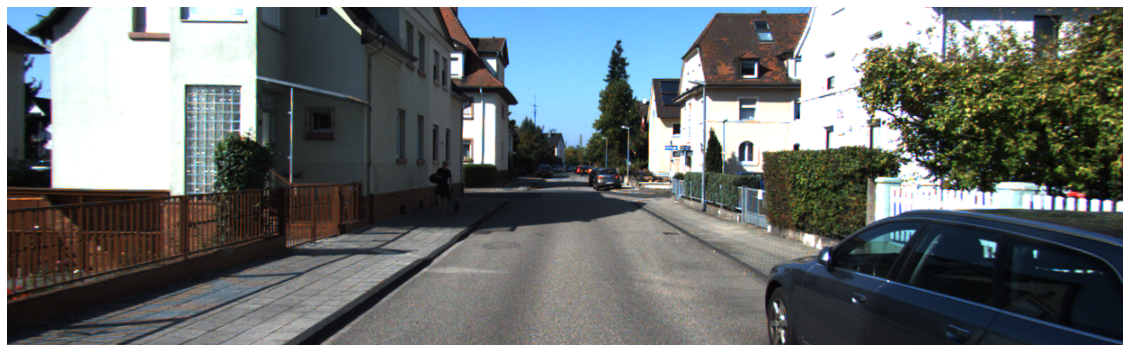

Ground Truth Depth Map


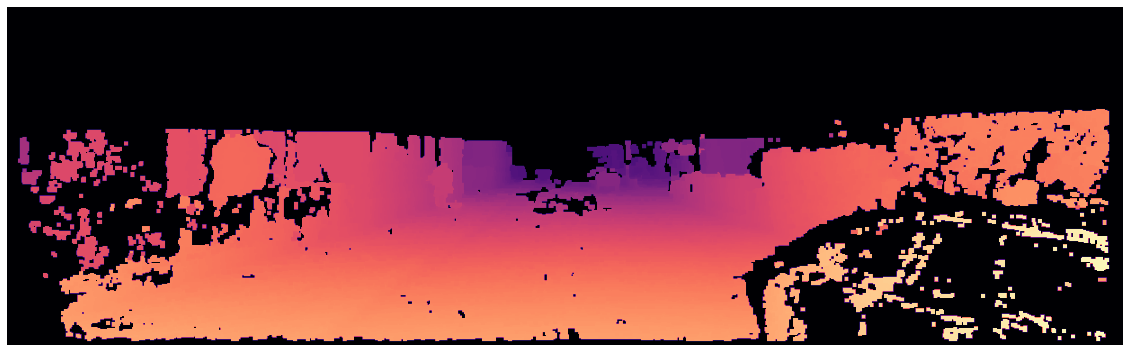

Predicted Depth Map


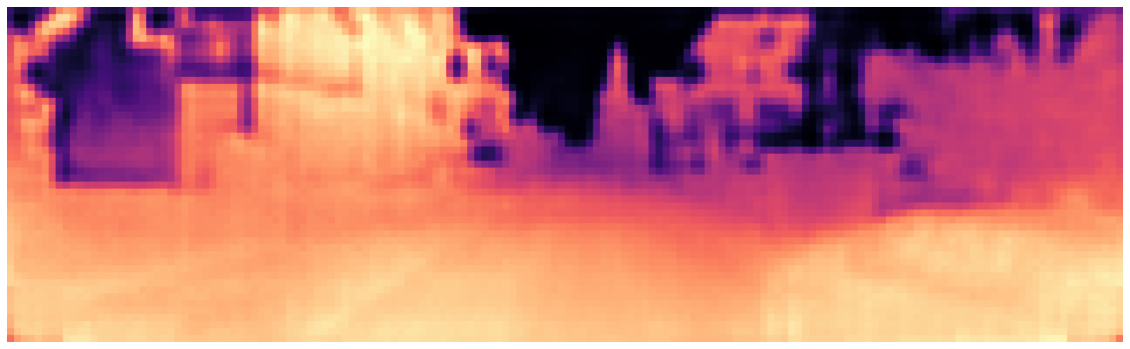

In [9]:
# Choose image index from val dataset
INDEX = 800
model.eval()
model.cuda()

# Untransformed data
sample = kitti_val_dataset.get(INDEX, transform=False)
rgb = sample["rgb"]
depth = sample["depth"]

# Data transformed for input to model
sample_tensor = kitti_val_dataset[INDEX]
rgb_tensor = sample_tensor["rgb"]

predicted_depth_tensor = model(rgb_tensor.unsqueeze(0).cuda())
predicted_depth_tensor = F.interpolate(predicted_depth_tensor, size=rgb_tensor.shape[1:3])
predicted_depth = model_depth_output_to_numpy(predicted_depth_tensor)

print("RGB Input")
show_sample(rgb=rgb)
print("Ground Truth Depth Map")
show_sample(depth=depth)
print("Predicted Depth Map")
show_sample(depth=predicted_depth)

# Optionally Save Model

In [10]:
print("Saving to", MODEL_PATH)
torch.save(model.state_dict(), MODEL_PATH)

Saving to ../models/20-real-100-virtual.pt


# Evalute on Test Dataset

In [10]:
test_dataset = KittiDepthDataset(KITTI_DIR, transform=val_transform, subset="test")
metrics = evaluate_model(model, test_dataset, limit=250)
print(f"Metrics for model {MODEL_NAME}")
pprint(metrics)


Metrics for model 0-real-100-virtual
{'a1': 0.08872555591749963,
 'a2': 0.15390580691617942,
 'a3': 0.24924631817168721,
 'abs_rel': 0.6980683989544088,
 'rmse': 41792.65531068482,
 'rmse_log': 1.5409588885608883,
 'sq_rel': 27858.58671938593}
